(parameters_recovery)=
# Recovering computational parameters from the observed behaviours

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/4-Parameter_recovery.ipynb)

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install pyhgf watermark

In [2]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
from numpy import loadtxt

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution, hgf_logp
from pyhgf.model import HGF
from pyhgf.response import binary_softmax_inverse_temperature

In [3]:
np.random.seed(123)

An important application of Hierarchical Gaussian Filters consists in the inference of computational parameters from observed behaviours, as well as the inference of data-generating models (e.g. are the participants answering randomly or are they learning environmental volatilities that are better approached with a Rescorla-Wagner or a Hierarchical Gaussian Filter?). **Parameter recovery** refers to the ability to recover true data-generating parameters; **model recovery** refers to the ability to correctly identify the true data-generating model using model comparison techniques. It is often a good idea to test parameter/model recovery of a computational model using simulated data before applying this model to experimental data {citep}`RobertCollins2019`. In this tutorial, we are going to demonstrate how to recover some parameters of the generative model of the Hierarchical Gaussian Filter.

## Simulate behaviours from a one-armed bandit task
Using a given task structure, we are going to simulate behaviours from a group of participants assuming that they are updating beliefs of environmental volatility using a two-level Hierarchical Gaussian Filter, using a simple sigmoid as a response function parametrized by an inverse temperature parameter. For each participant, the inverse temperature and the tonic volatility at the second level are free parameters that will be estimated during the inference step.

In [4]:
# u is the vector encoding the presence/absence of association
u, _ = load_data("binary")

In [5]:
def sigmoid(x, temperature):
    """The sigmoid response function with an inverse temperature parameter."""
    return (x**temperature) / (x**temperature + (1-x)**temperature)

In [33]:
N = 40  # number of agents to simulate

# sample one value for the inverse temperature (here in log space) and simulate responses
temperatures = np.ones(N)

# sample one new value of the tonic volatility at the second level and fit to observations
volatilities = np.linspace(-6.0, -0.5, num=N)

# create just one default network - we will simply change the values of interest before fitting to save time
agent = HGF(
    n_levels=2,
    verbose=False,
    model_type="binary",
    initial_mean={"1": 0.5, "2": 0.0},
)

In [34]:
# observations (always the same), simulated decisions, sample values for temperature and volatility
responses = []
for i in range(N):
    # set the tonic volatility for this agent and run the perceptual model forward
    agent.attributes[2]["tonic_volatility"] = volatilities[i]
    agent.input_data(input_data=u)

    # get decision probabilities using the belief trajectories
    # and the sigmoid decision function with inverse temperature
    p = sigmoid(
        x=agent.node_trajectories[1]["expected_mean"], temperature=temperatures[i]
    )

    # save the observations and decisions separately
    responses.append(np.random.binomial(p=p, n=1))

In [35]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=[u] * N,  # the inputs are the same for all agents - just duplicate the array
    response_function=binary_softmax_inverse_temperature,
    response_function_inputs=responses,
)

In [36]:
with pm.Model() as two_levels_binary_hgf:
    # tonic volatility
    volatility = pm.Normal("volatility", -2.0, 5, shape=(N,))

    # inverse temperature
    #inverse_temperature = pm.LogNormal("inverse_temperature", 1.0, 1.0, shape=(N,))

    # The multi-HGF distribution
    # --------------------------
    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            tonic_volatility_2=volatility,
            #response_function_parameters=inverse_temperature,
        ),
    )

## Sampling

In [42]:
pm.find_MAP(model=two_levels_binary_hgf)

{'volatility': array([-3.54045587, -3.01559912, -3.25934229, -2.75834261, -3.06843947,
        -3.2579263 , -2.80474394, -2.96909573, -2.8316838 , -3.08060149,
        -2.99466147, -3.19376658, -3.07638732, -3.08514911, -3.06952166,
        -2.94714088, -2.77637253, -2.87155903, -3.01431005, -2.34903269,
        -2.41300713, -2.39367347, -2.40233607, -2.67515292, -2.38050075,
        -1.8740198 , -2.38263969, -2.10725836, -2.28502444, -2.28187807,
        -1.96557851, -1.73584373, -1.53545935, -1.83234744, -1.54434061,
        -1.6612568 , -1.68129168, -1.27782111, -1.30303321, -1.1104911 ])}

In [37]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [volatility]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 449 seconds.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


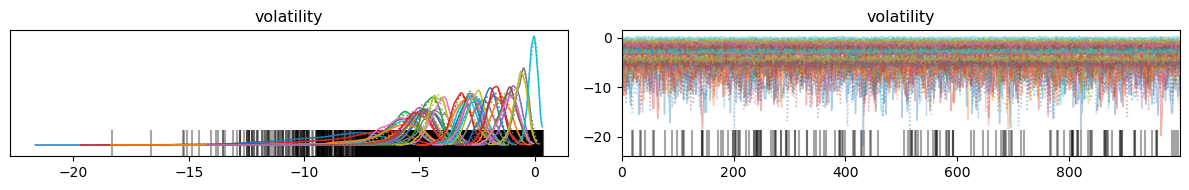

In [38]:
az.plot_trace(two_level_hgf_idata)
plt.tight_layout()

## Parameters recovery

In [39]:
temperatures = np.ones(N)

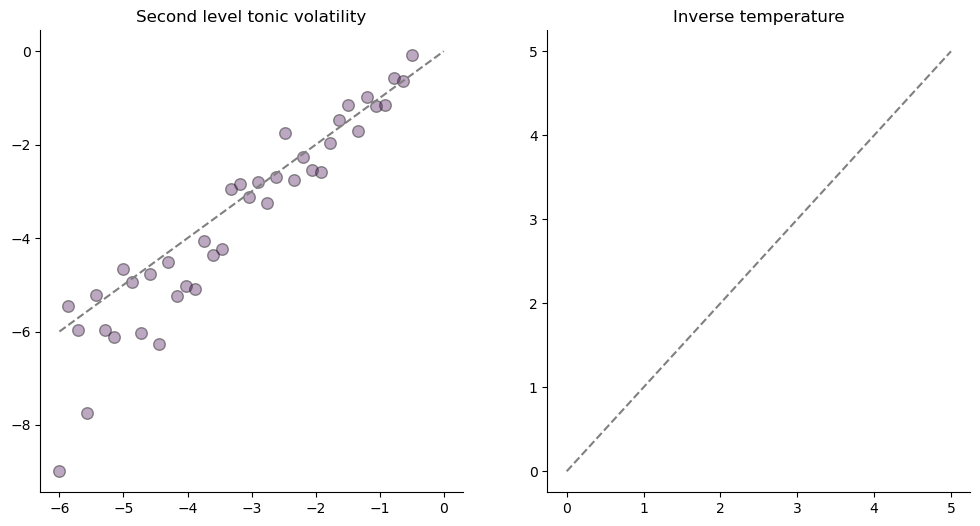

In [40]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
axs[0].plot([-6.0, 0.0], [-6.0, 0.0], color="grey", linestyle="--")
axs[1].plot([0.0, 5.0], [0.0, 5.0], color="grey", linestyle="--")

for var_name, refs, idx in zip(
    ["volatility"], [volatilities], [0, 1]
):
    for i in range(N):
        mean = (
            az.summary(two_level_hgf_idata, var_names=var_name)[
                ["mean"]
            ]
            .iloc[i]
            .to_list()
        )

        axs[idx].scatter(
            refs[i],
            mean,
            s=70,
            alpha=.4,
            edgecolors="k",
            color="#582766",
        )

axs[0].set_title("Second level tonic volatility")
axs[1].set_title("Inverse temperature")
sns.despine()

# System configuration

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib